# Regression Week 4: Ridge Regression (gradient descent)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = pd.read_csv('kc_house_data.csv')

# Import useful functions from previous notebook

In [3]:
def get_numpy_data(data_frame, features, output):
    data_frame['constant'] = 1
    features = ['constant'] + features # this is how you combine two lists
    features_frame = data_frame[features]
    feature_matrix = features_frame.as_matrix()
    output_series = data_frame[output]
    output_array = output_series.as_matrix()
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [4]:
def predict_output(feature_matrix, weights):
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Computing the Derivative

In [5]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)
    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2 * l2_penalty * weight
    return derivative

To test your feature derivartive run the following:

In [6]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-5.6554166816e+13
-5.6554166816e+13

-22446749330.0
-22446749330.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [15]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 1
    #while not reached maximum number of iterations:
    while iteration <= max_iterations:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                weights[i] -= weights[i] - step_size * feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, True)
            # subtract the step size times the derivative from the current weight
            weights[i] -= weights[i] - step_size * feature_derivative_ridge(errors, feature_matrix[:, i], weights[i], l2_penalty, False)
        iteration += 1
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [9]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_data,test_data = train_test_split(sales, train_size=0.8, random_state=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [12]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [13]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [17]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 0, max_iterations)

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [18]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, 1e11, max_iterations)

This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

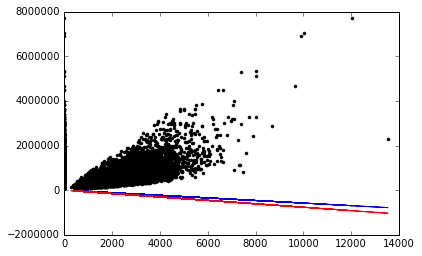

In [21]:
plt.plot(simple_feature_matrix, output,'k.',
     simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix, predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [26]:
residual_noreg = predict_output(simple_test_feature_matrix, simple_weights_0_penalty) - test_output
rss_noreg = sum(residual_noreg * residual_noreg)
print "noreg coefficients: " + str(simple_weights_0_penalty[1])
print "rss_noreg: " + str(rss_noreg)

noreg coefficients: -57.8005476354
rss_noreg: 2.45485286795e+15


In [27]:
residual_reg = predict_output(simple_test_feature_matrix, simple_weights_high_penalty) - test_output
rss_reg = sum(residual_reg * residual_reg)
print "reg coefficients: " + str(simple_weights_high_penalty[1])
print "rss_reg: " + str(rss_reg)

reg coefficients: -76.424390612
rss_reg: 2.72146178942e+15


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [28]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [29]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [30]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 0, 1000)

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [31]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, 1e11, 1000)

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [32]:
residual_noreg = predict_output(test_feature_matrix, multiple_weights_0_penalty) - test_output
rss_noreg = sum(residual_noreg * residual_noreg)
print "noreg coefficients: " + str(multiple_weights_0_penalty[1])
print "rss_noreg: " + str(rss_noreg)

noreg coefficients: -70.1166108938
rss_noreg: 3.53273754477e+15


In [33]:
residual_reg = predict_output(test_feature_matrix, multiple_weights_high_penalty) - test_output
rss_reg = sum(residual_reg * residual_reg)
print "reg coefficients: " + str(multiple_weights_high_penalty[1])
print "rss_reg: " + str(rss_reg)

reg coefficients: -99.6120048679
rss_reg: 4.51234886626e+15


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [35]:
np.dot(test_feature_matrix[0], multiple_weights_0_penalty) - test_output[0]

-487835.38241954753

In [36]:
np.dot(test_feature_matrix[0], multiple_weights_high_penalty) - test_output[0]

-568407.2122222546

***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?